In [58]:
!pip install numpy pandas matplotlib graphviz scikit-learn xgboost  -i https://mirrors.aliyun.com/pypi/simple/

Looking in indexes: https://mirrors.aliyun.com/pypi/simple/


参考资料：

* 文字：https://www.zhihu.com/question/58883125/answer/2551395292
* 视频：https://www.bilibili.com/video/BV1Zk4y1F7JE/
* 代码：https://randomrealizations.com/posts/xgboost-from-scratch/ 

In [59]:
import math
import numpy as np 
import pandas as pd
from collections import defaultdict
import xgboost as xgb
import matplotlib.pyplot as plt
from graphviz import Digraph

# Tree

In [60]:
# 代表一颗树中的某个node
class TreeBooster():
    def __init__(self, X, g, h, params, max_depth, idxs=None):
        # 各种超参数
        self.params = params
        self.max_depth = max_depth
        assert self.max_depth >= 0, 'max_depth must be nonnegative'
        
        self.learning_rate = self.params['learning_rate'] if self.params['learning_rate'] else 0.3
        
        self.min_child_weight = params['min_child_weight'] if params['min_child_weight'] else 1.0  
        self.colsample_bynode = params['colsample_bynode'] if params['colsample_bynode'] else 1.0
        
        self.reg_lambda = params['reg_lambda'] if params['reg_lambda'] else 1.0 # λ超参，公式的重要部分
        self.gamma = params['gamma'] if params['gamma'] else 0.0 # γ超参，公式的重要部分
        
        # 每个样本的Loss一阶导数，常数
        if isinstance(g, pd.Series):
            g = g.values
        # 每个样本的Loss二阶导数，常数
        if isinstance(h, pd.Series): 
            h = h.values
            
        # 参与训练的样本index，默认所有
        if idxs is None: 
            idxs = np.arange(len(g))
            
        # X：特征   g：Loss一阶导数   h：Loss二阶导数，idxs：参与训练的样本index
        self.X, self.g, self.h, self.idxs = X, g, h, idxs
        
        # n：样本数, c：特征数
        self.n, self.c = len(idxs), X.shape[1] 
        
        # Tree目标最小化的时候，Wj的取值计算.
        # 如果当前Node就是叶子，那么其Wj就是所有传入的样本计算而成的
        self.value = -g[idxs].sum() / (h[idxs].sum() + self.reg_lambda)
        self.best_score_so_far = 0.
        self.is_leaf=True
        
        # 如果允许分裂节点，那么就继续递归
        if self.max_depth > 0:
            self._maybe_insert_child_nodes() # 为当前节点找到一个分裂条件，产生左右两颗子树，让样本落入两颗子树，每颗子树又可以继续更新自己的Wj或者继续递归分裂

    def _maybe_insert_child_nodes(self):
        # 遍历每一个特征，判断是否适合作为分裂条件
        for i in range(self.c):
            self._find_better_split(i)
        
        # 没找到合适的分裂点，那么就不分裂了，自己就是叶子，直接用value作为W值
        if self.is_leaf: 
            return

        # 作为分裂条件的特征
        x = self.X.values[self.idxs,self.split_feature_idx]
        
        # <=分裂点的落入左子树
        left_idx = np.nonzero(x <= self.threshold)[0]
        # 其他落入右子树
        right_idx = np.nonzero(x > self.threshold)[0]
        # 递归构建左右子树
        self.left = TreeBooster(self.X, self.g, self.h, self.params, self.max_depth - 1, self.idxs[left_idx])
        self.right = TreeBooster(self.X, self.g, self.h, self.params, self.max_depth - 1, self.idxs[right_idx])
    
    def _find_better_split(self, feature_idx):
        # 取出这一列特征
        x = self.X.values[self.idxs, feature_idx]
        # 取出所有样本的g和h导数
        g, h = self.g[self.idxs], self.h[self.idxs]
        
        # 这一列特征值从小到大，对样本进行排序
        sort_idx = np.argsort(x)
        sort_g, sort_h, sort_x = g[sort_idx], h[sort_idx], x[sort_idx]  # g和h也跟随排序
        
        sum_g, sum_h = g.sum(), h.sum()
        sum_g_right, sum_h_right = sum_g, sum_h
        sum_g_left, sum_h_left = 0., 0.

        # 遍历每一个样本
        for i in range(0, self.n-1):
            g_i, h_i, x_i, x_i_next = sort_g[i], sort_h[i], sort_x[i], sort_x[i+1]
            
            # 以样本i的特征值作为分割点，计算H_left,G_left,H_right,G_right
            sum_g_left += g_i; sum_g_right -= g_i
            sum_h_left += h_i; sum_h_right -= h_i
            
            # 子树不能太小
            if sum_h_left < self.min_child_weight or sum_h_right < self.min_child_weight:
                continue
            
            # 求分裂和不分裂的目标值之差，寻找差距最大的，也就是分裂后目标值变的更小的
            gain = 0.5 * ((sum_g_left**2 / (sum_h_left + self.reg_lambda)) + (sum_g_right**2 / (sum_h_right + self.reg_lambda)) - (sum_g**2 / (sum_h + self.reg_lambda))) - self.gamma
            if gain > self.best_score_so_far: 
                self.split_feature_idx = feature_idx # 用哪个特征作为条件
                self.best_score_so_far = gain
                self.threshold = (x_i+x_i_next)/2 # 用哪个值作为分割点
                self.is_leaf=False
                
    def predict(self, X):
        return np.array([self._predict_row(row) for i, row in X.iterrows()])
    
    def get_score_by_weight(self,scores):
        if self.is_leaf:
            return 
        scores[self.split_feature_idx]+=1.0
        self.left.get_score_by_weight(scores)
        self.right.get_score_by_weight(scores)
        
    def plot_tree(self,dot,feature_names,parent,is_left=False):
        if self.is_leaf:
            dot.node(str(id(self)), f'left={self.value*self.learning_rate}') # 仿照xgboost，这里要乘以学习率再画出来，就像boosting推理过程一样
        else: 
            dot.node(str(id(self)), f'{feature_names[self.split_feature_idx]}<={self.threshold}')
            self.left.plot_tree(dot,feature_names,self,is_left=True)
            self.right.plot_tree(dot,feature_names,self,is_left=False)
        if parent:
            dot.edge(str(id(parent)),str(id(self)),label='yes' if is_left else 'no')
        return dot

    # 预测就是根据树的结构，将样本落入到某个叶子节点，得到该叶子节点的Wj
    def _predict_row(self, row):
        if self.is_leaf: 
            return self.value
        child = self.left if row.iloc[self.split_feature_idx] <= self.threshold else self.right
        return child._predict_row(row)

# Model

In [61]:
class XGBoostModel():
    '''XGBoost from Scratch
    '''
    
    def __init__(self, params, random_seed=None):
        self.params = defaultdict(lambda: None, params)
        self.subsample = self.params['subsample'] if self.params['subsample'] else 1.0
        self.learning_rate = self.params['learning_rate'] if self.params['learning_rate'] else 0.3
        self.base_prediction = self.params['base_score'] if self.params['base_score'] else 0.5
        self.max_depth = self.params['max_depth'] if self.params['max_depth'] else 5
        self.rng = np.random.default_rng(seed=random_seed)
                
    def fit(self, X, y, objective, num_boost_round, verbose=False):
        current_predictions = self.base_prediction * np.ones(shape=y.shape)
        self.boosters = []
        for i in range(num_boost_round):
            gradients = objective.gradient(y, current_predictions) # 每个样本的Loss一阶导数，输入是目标值和累计预测值
            hessians = objective.hessian(y, current_predictions)   # 每个样本的Loss二阶导数，输入是目标值和累计预测值
            sample_idxs = None if self.subsample == 1.0 else self.rng.choice(len(y), size=math.floor(self.subsample*len(y)), replace=False) # 样本采样，这里先当全部样本都进入当前Tree的训练
            booster = TreeBooster(X, gradients, hessians, self.params, self.max_depth, sample_idxs) # 根据导数和样本，以目标函数最优为目标，就能生成一棵树，然后以目标函数最优直接可以算出各叶子节点的W值
            current_predictions += self.learning_rate * booster.predict(X)  # 更新预测值（不断boost提升而来）
            self.boosters.append(booster)
            if verbose: 
                print(f'[{i}] train loss = {objective.loss(y, current_predictions)}')
            
    def predict(self, X):
        # 逐步提升预测值
        return (self.base_prediction + self.learning_rate * np.sum([booster.predict(X) for booster in self.boosters], axis=0))
    
    # 特征重要性
    def get_score(self, importance_type='weight'):
        if importance_type not in ['weight']:
            raise ValueError('Invalid importance_type')
        
        # feature inddx -> score
        scores=defaultdict(int)
        
        if importance_type == 'weight':    
            for booster in self.boosters:
                booster.get_score_by_weight(scores)
        return scores
    
    # 绘制树图像
    def plot_tree(self,feature_names,num_trees=0):
        dot = Digraph(comment=f'Booster Tree {num_trees}')
        return self.boosters[num_trees].plot_tree(dot,feature_names,None)

# Train&Fit Regression

In [62]:
from sklearn.datasets import fetch_california_housing,load_diabetes
from sklearn.model_selection import train_test_split
    
X, y = load_diabetes(as_frame=True, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

In [63]:
class SquaredErrorObjective():
    # Loss
    # (y_i-pred_i_minus_1)^2 / 2
    def loss(self, y, pred):
        return np.mean(((y - pred)**2)*0.5)
    
    # Loss关于Pred的一阶导数
    def gradient(self, y, pred):
        return pred - y
    
    # Loss关于Pred的二阶导数
    def hessian(self, y, pred):
        return np.ones(len(y))

In [64]:
params = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'subsample': 1,
    'reg_lambda': 1.5,
    'gamma': 0.0,
    'min_child_weight': 25,
    'base_score': 0.0,
    'tree_method': 'exact',
    'objective': 'reg:squarederror'
}
num_boost_round = 50

# train the from-scratch XGBoost model
model_scratch = XGBoostModel(params)
model_scratch.fit(X_train, y_train, SquaredErrorObjective(), num_boost_round, verbose=False)

# train the library XGBoost model
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
model_xgb = xgb.train(params, dtrain, num_boost_round)

In [65]:
pred_scratch = model_scratch.predict(X_test)
pred_xgb = model_xgb.predict(dtest)
print(f'scratch loss: {SquaredErrorObjective().loss(y_test, pred_scratch)}')
print(f'xgboost loss: {SquaredErrorObjective().loss(y_test, pred_xgb)}')

scratch loss: 1627.5459107847084
xgboost loss: 1698.7818275946036


# Train&Fit Classify

In [66]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
    
X, y = load_breast_cancer(as_frame=True, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

In [67]:
# 补充实现BCE二值交叉熵损失【二分类问题】
class BinaryCrossEntropybjective():
    # BCE损失函数与导数：https://blog.csdn.net/zzl12880/article/details/128403845
    def loss(self, y, pred):
        return np.mean(-(y * np.log(1/(1+np.exp(-pred))) + (1 - y) * np.log(1 - np.exp(-pred))))
    
    # Loss关于Pred的一阶导数
    def gradient(self, y, pred):
        return 1.0/(1.0+np.exp(-pred)) - y
    
    # Loss关于Pred的二阶导数
    def hessian(self, y, pred):
        sigmoid_value= 1.0/(1.0+np.exp(-pred))
        return sigmoid_value * (1.0 - sigmoid_value)

In [68]:
params = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'subsample': 1.0,
    'reg_lambda': 1.5,
    'gamma': 0.0,
    'min_child_weight': 25,
    'base_score': 0.5,
    'tree_method': 'exact',
    'objective': 'binary:logitraw'
}
num_boost_round = 50

# train the from-scratch XGBoost model
model_scratch = XGBoostModel(params, random_seed=42)
model_scratch.fit(X_train, y_train, BinaryCrossEntropybjective(), num_boost_round, verbose=False)

def logregobj(preds, dtrain):
    labels = dtrain.get_label()
    preds = 1.0 / (1.0 + np.exp(-preds))
    grad = preds - labels
    hess = preds * (1.0 - preds)
    return grad, hess

# train the library XGBoost model
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
model_xgb = xgb.train(params, dtrain, num_boost_round,obj=logregobj)

In [69]:
pred_scratch=model_scratch.predict(X_test)
pred_xgb=model_xgb.predict(dtest)

In [70]:
def accuracy(y_test,pred):
    probs=1/(1+np.exp(-pred))
    classes=np.zeros_like(probs)
    classes[probs>0.5]=1

    # 计算准确率
    acc=(classes==y_test).sum()/len(classes)*100
    # numpy转float 
    return acc.item()

# 对比和xgboost官方的差异
print(f'scratch acc:{accuracy(y_test,pred_scratch)}')
print(f'xgboost acc:{accuracy(y_test,pred_xgb)}') 

scratch acc:94.15204678362574
xgboost acc:95.32163742690058


# 特征重要性

In [71]:
# 特征index转特征name
def mapping_score_to_features(score):
    global X
    features=X.columns
    return {features[i]:s for i,s in score.items()}

# 特征重要性
scratch_score=mapping_score_to_features( model_scratch.get_score(importance_type="weight") )
xgboost_score=model_xgb.get_score(importance_type="weight")

# 按特征名排序
scratch_score = dict(sorted(scratch_score.items(), key=lambda item: item[0]))
xgboost_score = dict(sorted(xgboost_score.items(), key=lambda item: item[0]))

print(f'scratch scores:{scratch_score}')
print(f'xgboost scores:{xgboost_score}')

scratch scores:{'mean area': 1.0, 'mean concave points': 3.0, 'mean concavity': 1.0, 'worst area': 2.0, 'worst concave points': 6.0, 'worst concavity': 1.0, 'worst perimeter': 7.0, 'worst radius': 1.0, 'worst texture': 1.0}
xgboost scores:{'mean area': 1.0, 'mean concave points': 3.0, 'mean concavity': 1.0, 'worst area': 2.0, 'worst concave points': 6.0, 'worst concavity': 1.0, 'worst perimeter': 7.0, 'worst radius': 1.0, 'worst texture': 1.0}


<BarContainer object of 9 artists>

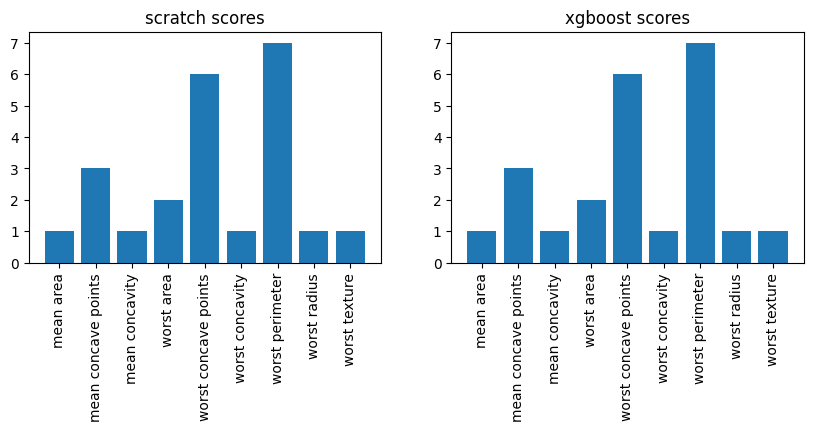

In [72]:
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.title('scratch scores')
plt.xticks(rotation=90)
plt.bar(scratch_score.keys(),scratch_score.values())

plt.subplot(1,2,2)
plt.title('xgboost scores')
plt.xticks(rotation=90)
plt.bar(scratch_score.keys(),scratch_score.values())

# 画出决策树

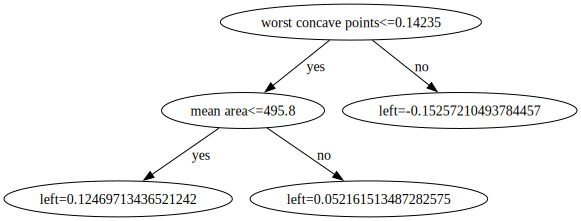

In [73]:
# 画出第5棵树
model_scratch.plot_tree(num_trees=5,feature_names=X.columns)

<Axes: >

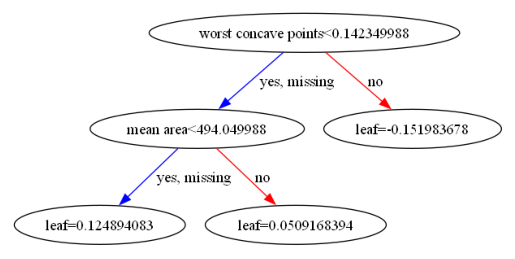

In [74]:
# 画出第5棵树
xgb.plot_tree(model_xgb,num_trees=5)